# Project 242

## Import

In [557]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [558]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [559]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


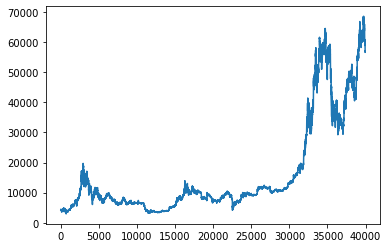

In [560]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [561]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [562]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [563]:
data = data.drop(['VWAP'], axis = 1)

In [564]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [565]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [566]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [567]:
# Add Signal
#q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)
#train_data['Signal'] = (train_data['Return'] >0).apply(int)
#test_data['Signal'] = (test_data['Return'] >0).apply(int)

In [568]:
train_data['Signal'].describe()

count    29936.000000
mean         0.017738
std          0.857426
min         -1.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Signal, dtype: float64

In [569]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (38.0%) | 0 (26.0%) | -1 (36.0%)
Test set: 1 (42.0%) | 0 (19.0%) | -1 (39.0%)


In [570]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [571]:
train = prepare_data_2D_format(train_data)
train.head()

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,BB_high_day_minus10,BB_low_day_minus10,EMA_day_minus10,...,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
0,8807.26,8844.00,8802.33,8810.28,7258435.18,-273.022667,29.828218,9425.124979,8717.193021,9019.536778,...,8826.99,8293169.22,-138.783500,35.971361,9306.755804,8602.062196,8929.658348,-52.721928,-138.783500,-1
1,4408.08,4625.85,4408.08,4580.00,142793.20,54.869667,64.484286,4458.014601,4219.454066,4353.888278,...,4591.88,20794.15,142.162000,61.253438,4629.816779,4211.853887,4449.361851,125.374357,142.162000,-1
2,5426.00,5510.00,5400.00,5500.40,22164357.30,150.433500,44.184404,5807.432405,4902.328928,5537.626375,...,5387.61,42590864.23,-42.154667,44.256608,5679.336314,5125.356353,5456.658784,-18.229418,-42.154667,-1
3,10395.98,10419.99,10310.00,10379.05,19028736.31,68.878333,56.529266,10402.888983,10213.381017,10323.907771,...,10315.57,4276600.82,-13.036333,51.238872,10390.898620,10256.126047,10322.110552,-24.515960,-13.036333,-1
4,7370.00,7435.00,7368.00,7421.88,15053867.20,45.698500,59.593511,7502.040422,7272.379578,7360.428764,...,7458.27,7582871.65,62.256500,59.016192,7506.542442,7276.500225,7399.109849,83.102962,62.256500,-1


In [572]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [573]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [574]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [575]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [576]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [577]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [578]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [579]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.133
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.172
Time:                        15:17:46   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.573e+04
Df Residuals:                   29794   BIC:                         7.657e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0302    

We perform feature selection using the p-value

In [580]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.144
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.155
Time:                        15:17:48   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.573e+04
Df Residuals:                   29795   BIC:                         7.656e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0301    

In [581]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.152
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.144
Time:                        15:17:50   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29796   BIC:                         7.655e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0303    

In [582]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.164
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        15:17:53   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29797   BIC:                         7.654e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0302    

In [583]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.164
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        15:17:56   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29797   BIC:                         7.654e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0302    

In [584]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.172
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.119
Time:                        15:17:58   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29798   BIC:                         7.653e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0299    

In [585]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.180
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.111
Time:                        15:18:01   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29799   BIC:                         7.652e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0297    

In [586]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.180
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.111
Time:                        15:18:04   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29799   BIC:                         7.652e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0297    

In [587]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.180
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.111
Time:                        15:18:06   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29799   BIC:                         7.652e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0297    

In [588]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.180
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.111
Time:                        15:18:09   Log-Likelihood:                -37762.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29799   BIC:                         7.652e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0297    

In [589]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.135
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.175
Time:                        15:18:11   Log-Likelihood:                -37765.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29801   BIC:                         7.651e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0332    

In [590]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.137
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.174
Time:                        15:18:12   Log-Likelihood:                -37766.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29802   BIC:                         7.650e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0315    

In [591]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.148
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.157
Time:                        15:18:13   Log-Likelihood:                -37766.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29803   BIC:                         7.649e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0315    

In [592]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.159
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.143
Time:                        15:18:15   Log-Likelihood:                -37766.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29804   BIC:                         7.648e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0272    

In [593]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.160
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.142
Time:                        15:18:16   Log-Likelihood:                -37767.
No. Observations:               29896   AIC:                         7.572e+04
Df Residuals:                   29805   BIC:                         7.647e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0260    

In [594]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.172
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.129
Time:                        15:18:17   Log-Likelihood:                -37767.
No. Observations:               29896   AIC:                         7.571e+04
Df Residuals:                   29806   BIC:                         7.646e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0267    

In [595]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.180
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.120
Time:                        15:18:19   Log-Likelihood:                -37767.
No. Observations:               29896   AIC:                         7.571e+04
Df Residuals:                   29807   BIC:                         7.645e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0263    

In [614]:
y_prob = reg.predict(test)

q75 = y_prob.mean() - y_prob.std()/3
q25 = y_prob.mean() + y_prob.std()/3

def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < q75: return -1
    if x < q25: return 0
    return 1

y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]),
        '0': len([x for x in y_pred if x == 0]),
       '-1': len([x for x in y_pred if x == -1])}
print(freq)

{'1': 4083, '0': 2839, '-1': 3046}


In [615]:
y_prob.describe()

count    9968.000000
mean       -0.126808
std         0.178032
min        -1.811076
25%        -0.215929
50%        -0.101283
75%        -0.016342
max         0.946924
dtype: float64

### 3. Test prediction model

In [616]:
TPR, FPR = 0, 0 #get_TPR_FPR(y_test, y_pred)
F1 = get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [617]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.341693,0.324751,0


### III. Strategy

### 1. Get data ready for backtesting

In [618]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [619]:
signal = pd.Series(y_pred).apply(translation)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.180778
std         0.983573
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max         1.000000
dtype: float64

In [620]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [621]:
strat = Strategy(cash=500, fees=0.001)

In [622]:
strat.run(signal_crop, close_crop, verbose=False)

In [623]:
wallet = np.array(strat.wallet)
profit = wallet[:-1] - wallet[1:]

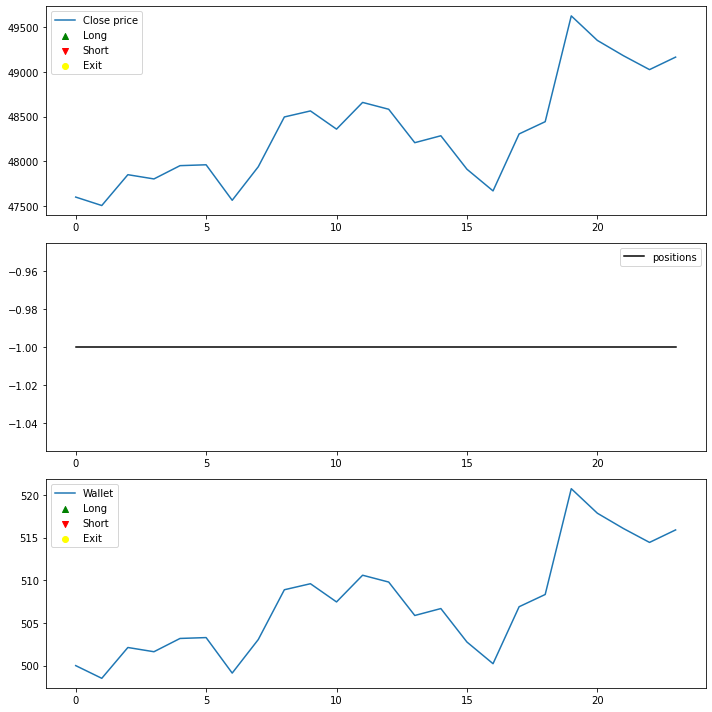

In [624]:
strat.visualize()

### 3. Test performance startegy

In [625]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [626]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,-0.174969,-12.403238,0.916667,-15.906585,-0.662774
